In [6]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
import json


In [7]:
with open('utils.py') as f:
    exec(f.read())


# Setup

In [8]:
median_income_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv"

training_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals_0926.csv"

In [9]:
df = pd.read_csv(training_data_source)

df = df.rename(columns={
    # 'Max Square Feet': 'square_feet',
    # 'Max Beds': 'bedrooms',
    # 'Max Baths': 'bathrooms',
    'price': 'rent',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})

basic_metadata = ["property_id", "address", "city", "state"]
basic_features = ["square_feet", "bedrooms", "bathrooms"]
target = "rent"


for feature in basic_features + [target, "latitude", "longitude"]:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')


df = df[(df["bedrooms"] > 0 ) 
        & (df["bedrooms"] < 6)  
        & (df["bathrooms"] < 4)  
        & (df["square_feet"] < 5000)  
        & (df["rent"] < 10000)  
        & (df["state_code"].notna()) 
        & (df["property_type"] == "6") 
    ]


# Get Median Income

In [10]:
cbg_geoid_col = 'cbg_geoid'  # Replace with the actual column name

df = get_median_income_data(df, cbg_geoid_col, median_income_data_source)

df = fill_null(df, columns_to_fill=['median_income'], method='median', groupby='state')

# Feature Engineering

In [11]:
clean_initial_df = df.dropna(subset=basic_features)

## One Hot Encoding

In [12]:
columns_to_encode = ['bedrooms', 'bathrooms']

# Apply one-hot encoding to the specified columns
df, one_hot_features = one_hot_encode_features(clean_initial_df, columns_to_encode, drop_first=True)

print("Encoded features:", one_hot_features)

Encoded features: ['bedrooms_2.0', 'bedrooms_3.0', 'bedrooms_4.0', 'bedrooms_5.0', 'bathrooms_1.0', 'bathrooms_1.5', 'bathrooms_2.0', 'bathrooms_2.5', 'bathrooms_3.0', 'bathrooms_3.5']


## Rent Benchmark with KNN

In [13]:
knn_features = ["latitude", "longitude"]
target = 'rent'
n_values = [1, 5, 10]
save_location = r'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models'

# Apply the KNN benchmark function
df, benchmark_features = create_knn_benchmark_rent(df, knn_features, target, n_values, save_location)

print("Benchmark features created:", benchmark_features)

Benchmark features created: ['Rent_Benchmark_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Rent_Benchmark_10_neighbors']


In [21]:
display(df[["Rent_Benchmark_1_neighbors", "rent"]])

# Calculate the percentage of time the two columns are equal
equal_percentage = (df["Rent_Benchmark_1_neighbors"] == df["rent"]).mean() * 100

# Display the result
print(f"The percentage of time 'Rent_Benchmark_1_neighbors' and 'rent' are equal is {equal_percentage:.2f}%")


,Rent_Benchmark_1_neighbors,rent
0,2000.0,2000.0
1,2000.0,2700.0
2,2000.0,2000.0
3,2000.0,2700.0
4,2995.0,2995.0
...,...,...
12849,1045.0,1045.0
12850,1379.0,1379.0
12851,1650.0,1650.0
12852,1550.0,1550.0


The percentage of time 'Rent_Benchmark_1_neighbors' and 'rent' are equal is 93.55%


## Scaling & Polynominal

In [14]:
potential_features = ["median_income"] + basic_features + one_hot_features + benchmark_features

In [15]:
# Split your data first
X_train, X_test, y_train, y_test = train_test_split(df[potential_features], df[target], train_size=0.8, random_state=27)

# Scale the training data
X_train_scaled, scaler = scale_features(X_train, mode='train')

# Generate polynomial features for the training data
X_train_poly, poly = generate_polynomial_features(X_train_scaled, original_feature_names=potential_features, mode='train', degree=2)

# Optionally, you can scale and transform the test data for evaluation purposes
X_test_scaled = scale_features(X_test, mode='predict')
X_test_poly = generate_polynomial_features(X_test_scaled, original_feature_names=potential_features, mode='predict', degree=2)


print("X_Train.shape: {}".format(X_train_scaled.shape))
print("X_Train_poly.shape: {}".format(X_train_poly.shape))

X_Train.shape: (10283, 17)
X_Train_poly.shape: (10283, 170)


# Feature Selection

In [32]:
ridge = Ridge()
rfecv = RFECV(estimator=ridge, step=1, cv=5, scoring='r2')
rfecv.fit(X_train_poly, y_train)


print("Optimal number of features: %d" % rfecv.n_features_)
selected_features_mask = rfecv.support_
feature_names = poly.get_feature_names_out(potential_features)
selected_features = [feature for feature, selected in zip(feature_names, selected_features_mask) if selected]

print("Selected features:", selected_features)

# Save the selected features to a file
with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f)

Optimal number of features: 72
Selected features: ['square_feet', 'bedrooms', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bathrooms_1.0', 'Rent_Benchmark_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Rent_Benchmark_10_neighbors', 'median_income^2', 'median_income bedrooms', 'median_income bathrooms', 'median_income bedrooms_2', 'median_income bathrooms_1.0', 'median_income bathrooms_1.5', 'median_income Rent_Benchmark_1_neighbors', 'median_income Rent_Benchmark_5_neighbors', 'square_feet bedrooms', 'square_feet bedrooms_2', 'square_feet bedrooms_3', 'square_feet bedrooms_4', 'square_feet bedrooms_5', 'square_feet bathrooms_1.0', 'square_feet bathrooms_1.5', 'square_feet Rent_Benchmark_1_neighbors', 'square_feet Rent_Benchmark_5_neighbors', 'square_feet Rent_Benchmark_10_neighbors', 'bedrooms^2', 'bedrooms Rent_Benchmark_1_neighbors', 'bedrooms Rent_Benchmark_5_neighbors', 'bedrooms Rent_Benchmark_10_neighbors', 'bathrooms bedrooms_2', 'bathrooms Rent_Benchmark_1_neighbors', 'bathrooms Re

Ridge: Mean R^2 = 0.9747, Std = 0.0039
Lasso: Mean R^2 = 0.9711, Std = 0.0050


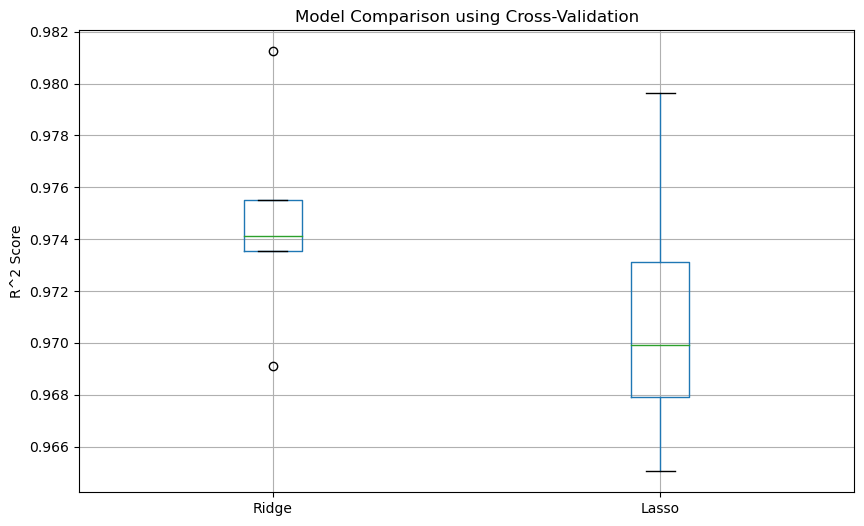

Best Model: Ridge
Test MAE: 40.9419
Test R^2: 0.9758


In [33]:
# Load the selected features
with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

#Scale features and Generate Polynominals
X = scale_features(df[potential_features], mode='predict')
X, poly = generate_polynomial_features(X, original_feature_names= potential_features, mode='predict', degree=2)

#Create Train and Test Sets
X = pd.DataFrame(X, columns=poly)
X = X[selected_features]
y = df[target]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, random_state=27)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=27)


#Select Model
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
}

results = {}


for model_name, model in models.items(): 
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    results[model_name] = scores
    print(f"{model_name}: Mean R^2 = {scores.mean():.4f}, Std = {scores.std():.4f}")

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title('Model Comparison using Cross-Validation')
plt.ylabel('R^2 Score')
plt.show()

# Optionally, train the best model on the combined training and validation set and evaluate on the test set
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
best_model.fit(X_train_val, y_train_val)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")
